In [1]:
from simple.ohlc import debounce, midPrice, TTrade
from simple.plotly import chartFigure
from simple.funcs import symlog, vPIN, cPIN, tickSpeed
from simple.pretty import pmap
from simple.jurik import JRSX, JTPO, JCFB
from simple.ehlers import reflex
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.subplot.left'] = 0.04
plt.rcParams['figure.subplot.right'] = 0.96
plt.rcParams['figure.subplot.top'] = 0.96
plt.rcParams['figure.subplot.bottom'] = 0.04
plt.rcParams['axes.grid'] = False
plt.rcParams['image.aspect'] = 'auto'

In [3]:
T = np.load('data/ETHUSDT.2022-05-08.tick.npz')['ETHUSDT'].view(np.recarray)[:100_000]
T[-5:], len(T)

(rec.array([('2022-05-08T01:01:46.276000', 102730, 2622.12,   2.),
            ('2022-05-08T01:01:46.289000', 102731, 2622.12,   2.),
            ('2022-05-08T01:01:46.390000', 102732, 2622.12, 406.),
            ('2022-05-08T01:01:46.509000', 102733, 2622.12, 192.),
            ('2022-05-08T01:01:46.509000', 102734, 2622.12,   8.)],
           dtype={'names':['DT','LocalDT','Price','Size'], 'formats':['<M8[us]','<i8','<f8','<f8'], 'offsets':[0,8,16,24], 'itemsize':40}),
 100000)

In [4]:
C = debounce(T)
C[-5:], len(C)

(rec.array([('2022-05-08T01:01:44.079000', 13140, 2622.035,       0,  9119.,  9119.,      0.,  5,  5,  0),
            ('2022-05-08T01:01:44.079000', 13141, 2622.065,       0,  2774.,  2774.,      0.,  4,  4,  0),
            ('2022-05-08T01:01:44.090000', 13142, 2622.095,   11000,  3735.,  3735.,      0.,  4,  4,  0),
            ('2022-05-08T01:01:44.092000', 13143, 2621.995,       0,  2449.,     0.,  -2449.,  1,  0,  1),
            ('2022-05-08T01:01:46.789000', 13144, 2622.115, 2417000, 27046., 11691., -15355., 80, 48, 32)],
           dtype=[('DT', '<M8[us]'), ('Index', '<i8'), ('Price', '<f8'), ('Duration', '<m8[us]'), ('Size', '<f8'), ('BuySize', '<f8'), ('SellSize', '<f8'), ('Count', '<i8'), ('BuyCount', '<i8'), ('SellCount', '<i8')]),
 13145)

In [5]:
Buy = T[T.Size > 0]
Sell = T[T.Size < 0]

In [6]:
len(T), len(C)

(100000, 13145)

In [7]:
C.Volume = C.BuySize + C.SellSize
Buy = C[C.Volume > 0]
Sell = C[C.Volume < 0]
Sell[-5:]

rec.array([('2022-05-08T01:01:38.744000', 13120, 2621.475,       0, 3.0000e+00,     0., -3.0000e+00,  1,  0,  1),
           ('2022-05-08T01:01:38.758000', 13121, 2621.445,       0, 1.1620e+03,     0., -1.1620e+03,  2,  0,  2),
           ('2022-05-08T01:01:40.211000', 13129, 2621.615,   33000, 1.5000e+02,     0., -1.5000e+02,  7,  0,  7),
           ('2022-05-08T01:01:44.092000', 13143, 2621.995,       0, 2.4490e+03,     0., -2.4490e+03,  1,  0,  1),
           ('2022-05-08T01:01:46.789000', 13144, 2622.115, 2417000, 2.7046e+04, 11691., -1.5355e+04, 80, 48, 32)],
          dtype=[('DT', '<M8[us]'), ('Index', '<i8'), ('Price', '<f8'), ('Duration', '<m8[us]'), ('Size', '<f8'), ('BuySize', '<f8'), ('SellSize', '<f8'), ('Count', '<i8'), ('BuyCount', '<i8'), ('SellCount', '<i8')])

In [8]:
# debounced chart without bidask
chartFigure(height=500,
    Sell=dict(x=Sell.Index, y=Sell.Price, color='red', mode='markers', size=symlog(Sell.Size)+1, opacity=0.75),
    Buy=dict(x=Buy.Index, y=Buy.Price, color='green', mode='markers', size=symlog(Buy.Size)-1, opacity=0.75),
)

FigureWidgetResampler({
    'data': [{'marker': {'color': 'red',
                         'opacity': 0.75,
   …

In [9]:
func = {
    'RSX': lambda period: JRSX(C.Price, period+20),
    'TPO': lambda period: JTPO(C.Price, period),
    'CFB': lambda period: JCFB(C.Price, 7, period),
    'Reflex': lambda period: reflex(C.Price, period),
    'Speed': lambda period: tickSpeed(C, period)
}

In [10]:
P = range(10, 1000, 10)
F = {name: pmap(func[name], P, postfix=name) for name in func}

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

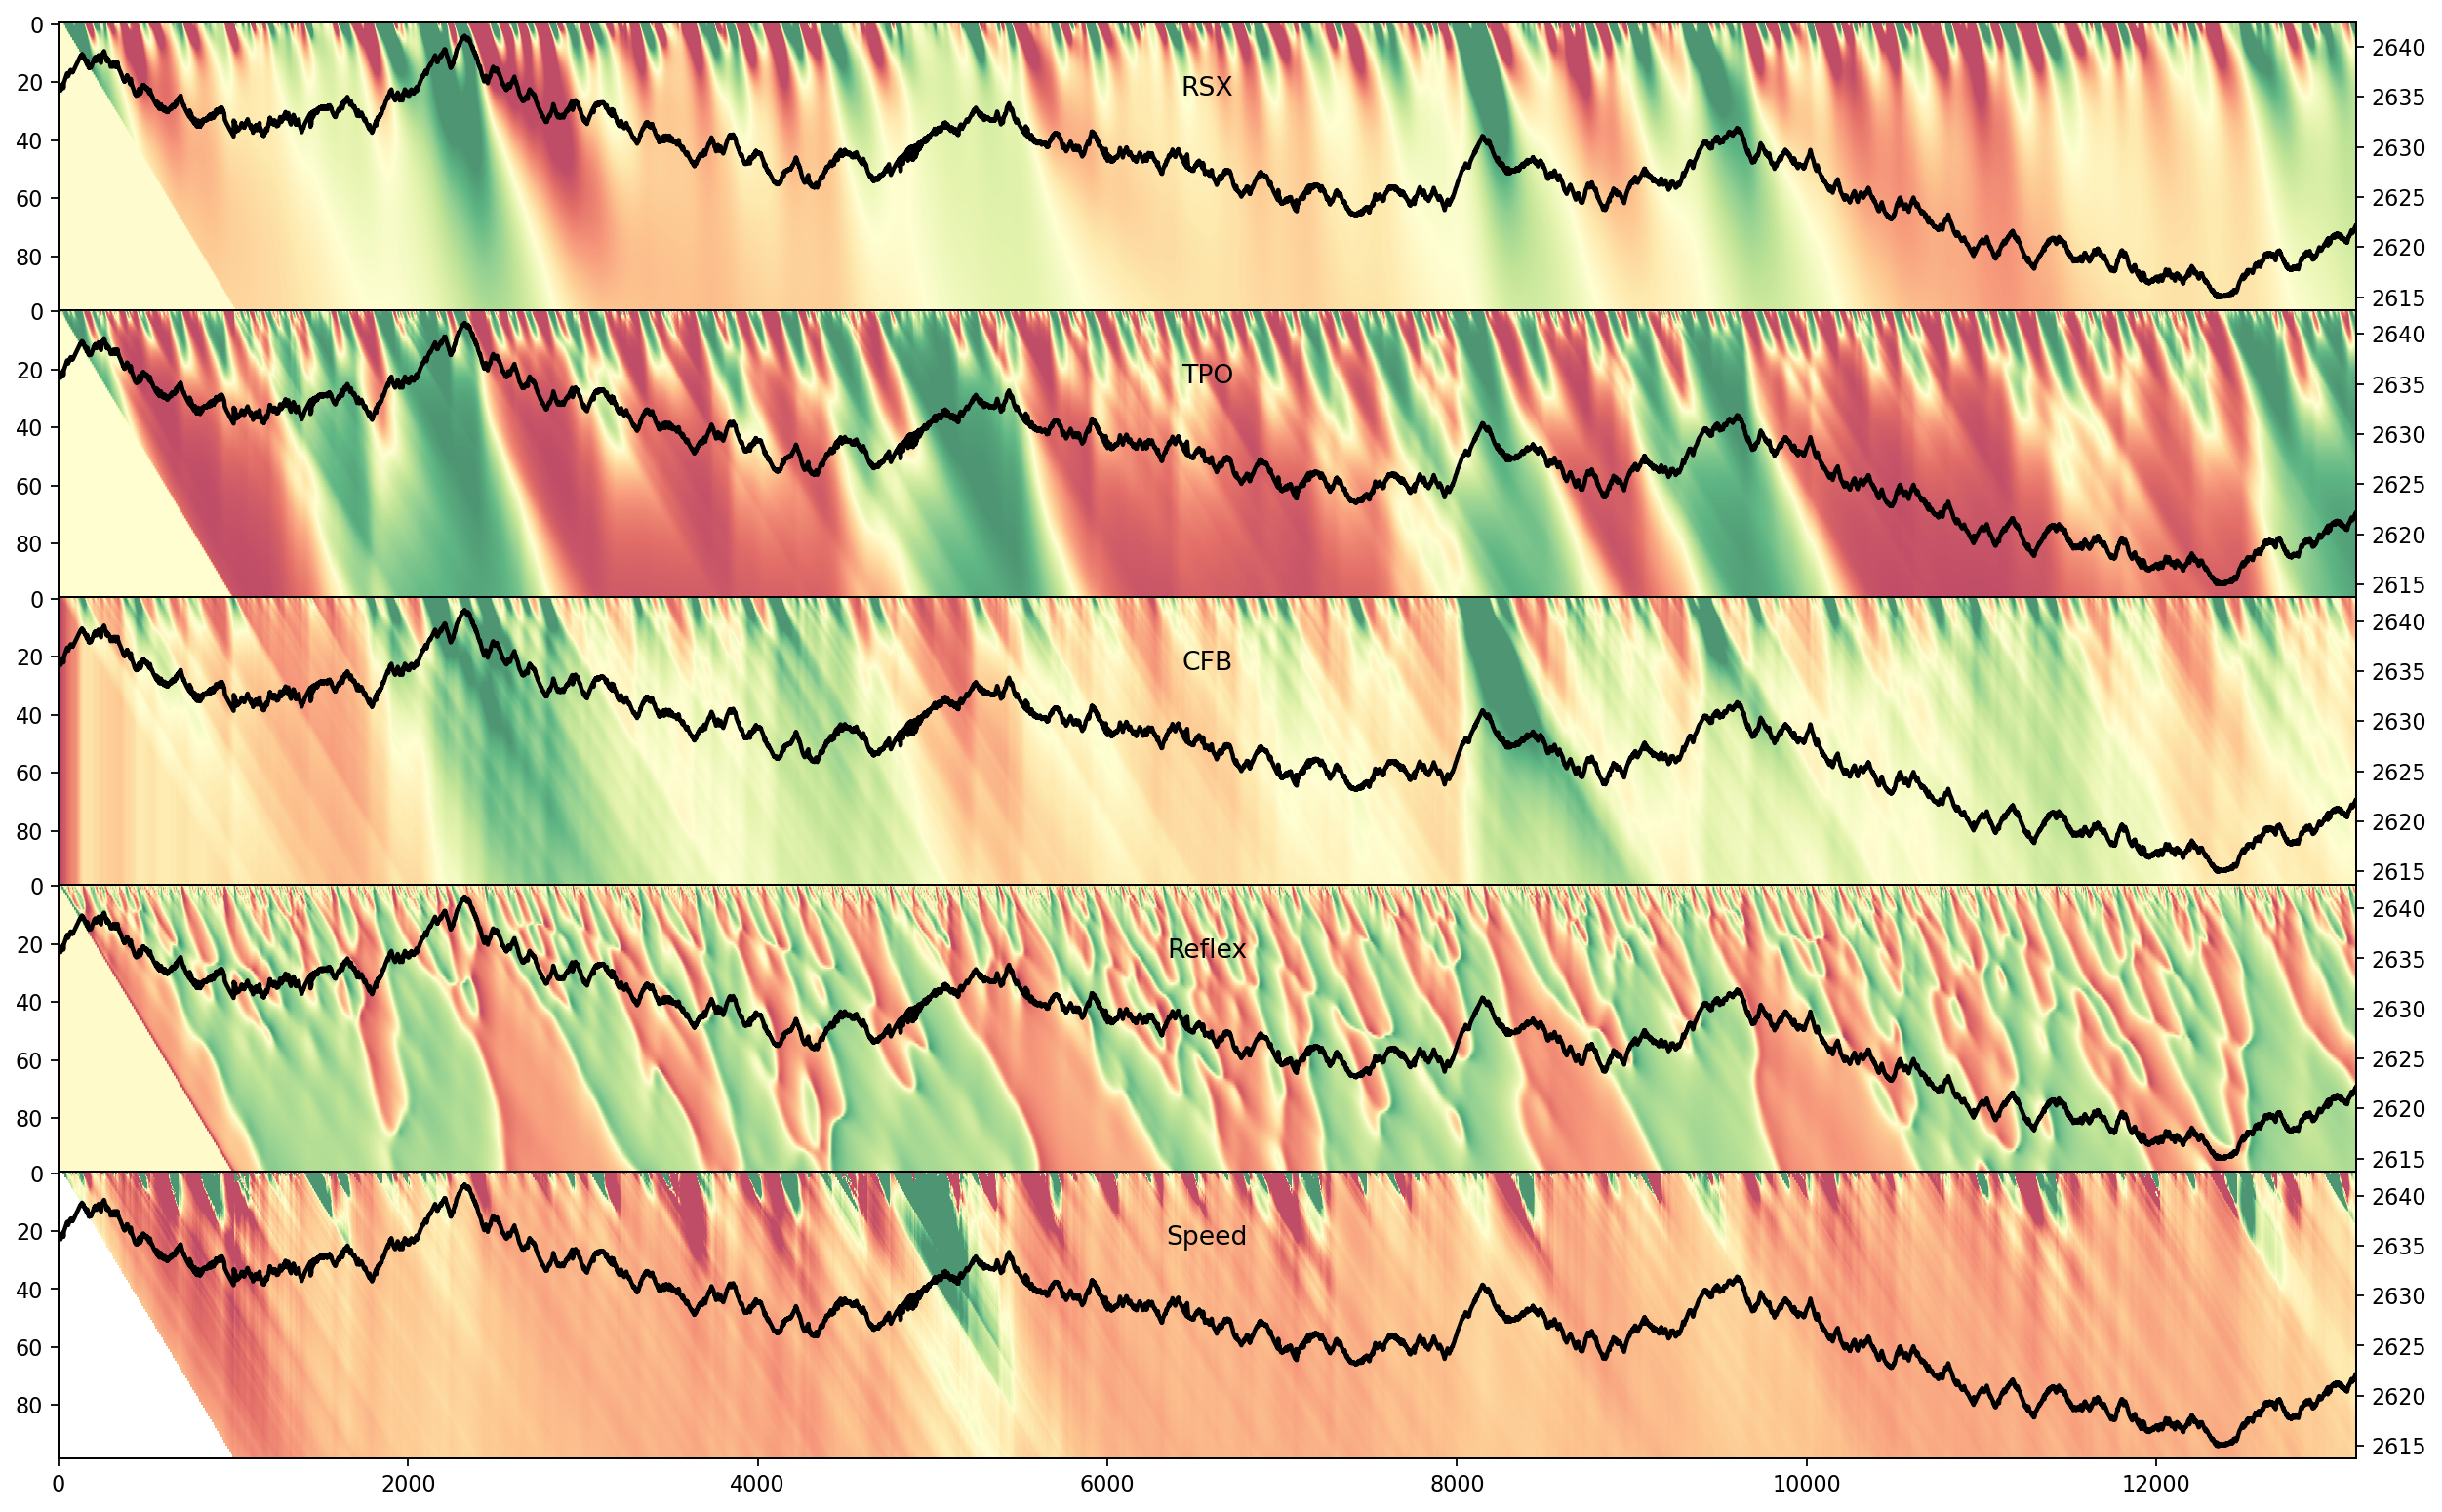

In [11]:
fig, axes = plt.subplots(len(func), 1, figsize=(16, len(func)*2), sharex='col')
fig.subplots_adjust(hspace=0)

for name, ax in zip(func, axes):
    X = np.nan_to_num(F[name][50])
    low, high = np.percentile(X, q=0.05), np.percentile(X, q=99.95)
    ax.imshow(F[name], cmap='RdYlGn', vmin=low, vmax=high, alpha=0.7)
    ax.set_title(name, y=0.7)
    ax.twinx().plot(C.Price, linewidth=2, color='black')